In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [97]:
# image_size = (160, 160)
# image_size_rgb = image_size

image_path = "all_files"

image_size = (50, 50)
image_size_rgb = (71, 71)

batch_size = 32
seeds = 42
num_classes = 8
validation_s = 0.2
labels = 'inferred'
label_mode="categorical"
# label_mode="int"


train_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    # labels=labels,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    # labels=labels,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)

train_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    # labels=labels,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size_rgb,
    batch_size=batch_size
)
val_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    # labels=labels,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size_rgb,
    batch_size=batch_size
)

Found 3179 files belonging to 8 classes.
Using 2544 files for training.
Found 3179 files belonging to 8 classes.
Using 635 files for validation.
Found 3179 files belonging to 8 classes.
Using 2544 files for training.
Found 3179 files belonging to 8 classes.
Using 635 files for validation.


In [98]:
class_names = train_ds.class_names
print(class_names)

['10', '12', '1235', '15', '17', '2', '21', '38']


In [99]:
buffer_size = 32

train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


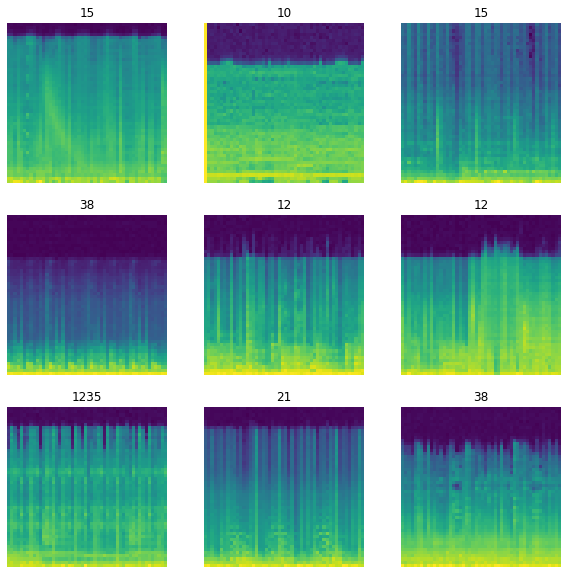

In [100]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [101]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [102]:
normalization_layer = layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3))

In [103]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-01-22 21:31:52.444620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 38 of 1000


0.33376786 0.92835146


2022-01-22 21:32:00.908476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [104]:
# image, label = next(iter(train_ds))
# image = image[0]
# print(image)
# _ = plt.imshow(image)

In [105]:
# rescale = tf.keras.Sequential([
#   layers.Rescaling(scale=1.0 / 127.5, offset=-1)
#   # layers.Rescaling(scale=1.0 / 255)
# ])

# result = rescale(image)

# plt.imshow(image)
# print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

In [106]:
## Model parameters:
main_activation = "relu"
last_activation = None
bias = True
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = None
rescaling_layer = layers.Rescaling(1.0 / 255)
# rescaling_layer = layers.Rescaling(scale=1.0 / 127.5, offset=-1)

In [107]:
def make_model_DNN(input_shape, num_classes):
    model = keras.models.Sequential()
    
    # model.add(layers.Rescaling(1.0 / 255))
    model.add(rescaling_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    # model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    # model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    model.add(layers.Dense(num_classes, activation=last_activation))
    return model

model_DNN = make_model_DNN(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model_DNN, show_shapes=True)

In [108]:
# def make_model_bas(input_shape, num_classes):
#     initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
#     model = keras.models.Sequential()
#     model.add(layers.Rescaling(1.0 / 255))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_initializer=initializer,use_bias=True))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(32, activation='sigmoid',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.Dense(num_classes))
#     return model

# model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# # keras.utils.plot_model(model, show_shapes=True)
# # model_bas.summary()

In [109]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(32, 3,  padding="same", activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3,  padding="same", activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3,  padding="same", activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(64, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)

    x = layers.Dense(32, activation=last_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 conv2d_133 (Conv2D)         (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                     

In [110]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(16, 3, padding='same', activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 conv2d_136 (Conv2D)         (None, 50, 50, 16)        160       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 25, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_137 (Conv2D)         (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                     

In [111]:
def make_model_adv(input_shape, num_classes, chanels=3):
    inputs = keras.Input(shape=input_shape)
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
    initializer = None
    # Entry block
    # x = layers.Rescaling(1.0 / 255)(inputs)
    x = rescaling_layer(inputs)
    # x = layers.Conv2D(32, chanels, strides=2, padding="same")(x)
    x = layers.Conv2D(32, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    # x = layers.Conv2D(64, chanels, padding="same")(x)
    x = layers.Conv2D(64, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
    # for size in [128, 256]:
        x = layers.Activation(main_activation)(x)
        # x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.SeparableConv2D(size, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(main_activation)(x)
        # x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.SeparableConv2D(size, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # residual = layers.Conv2D(size, chanels, strides=2, padding="same")(
        #     previous_block_activation
        # )
        residual = layers.Conv2D(size, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation=main_activation)(x)

    # if num_classes == 2:
    #     activation = "sigmoid"
    #     units = 1
    # else:
    #     activation = "softmax"
    #     units = num_classes
    
    units = num_classes

    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units, activation=last_activation, kernel_initializer=initializer,use_bias=True)(x)
    # outputs = layers.Dense(units, activation=activation,kernel_initializer=initializer,use_bias=True)(x)
    return keras.Model(inputs, outputs)


model_adv = make_model_adv(input_shape=image_size + (1,), num_classes=num_classes,chanels=1)
# keras.utils.plot_model(model_adv, show_shapes=True)
model_adv.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 50, 50, 1)    0           ['input_42[0][0]']               
                                                                                                  
 conv2d_139 (Conv2D)            (None, 25, 25, 32)   64          ['rescaling_10[2][0]']           
                                                                                                  
 batch_normalization_148 (Batch  (None, 25, 25, 32)  128         ['conv2d_139[0][0]']             
 Normalization)                                                                            

In [112]:
def make_model_adv_bas(input_shape, num_classes, chanels=3):
    inputs = keras.Input(shape=input_shape)
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
    initializer = None
    # Entry block
    x = rescaling_layer(inputs)
    x = layers.Conv2D(32, chanels, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.Conv2D(64, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
    # for size in [128, 256]:
        x = layers.Activation(main_activation)(x)
        x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(main_activation)(x)
        x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, chanels, strides=2, padding="same")(
            previous_block_activation
        )
        # residual = layers.Conv2D(size, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=True)(
        #     previous_block_activation
        # )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation=main_activation)(x)

    # if num_classes == 2:
    #     activation = "sigmoid"
    #     units = 1
    # else:
    #     activation = "softmax"
    #     units = num_classes
    
    units = num_classes

    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units, activation=last_activation,use_bias=True)(x)
    # outputs = layers.Dense(units, activation=activation,kernel_initializer=initializer,use_bias=True)(x)
    return keras.Model(inputs, outputs)


model_adv_bas = make_model_adv_bas(input_shape=image_size + (1,), num_classes=num_classes,chanels=1)
# keras.utils.plot_model(model_adv, show_shapes=True)
model_adv.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 50, 50, 1)    0           ['input_42[0][0]']               
                                                                                                  
 conv2d_139 (Conv2D)            (None, 25, 25, 32)   64          ['rescaling_10[2][0]']           
                                                                                                  
 batch_normalization_148 (Batch  (None, 25, 25, 32)  128         ['conv2d_139[0][0]']             
 Normalization)                                                                            

In [113]:
def make_model_im_net(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  inputs = layers.Rescaling(1.0 / 255)(inputs)

  input_shape_rgb = (input_shape[0], input_shape[1], 3)

  base_model = tf.keras.applications.Xception(input_shape = input_shape_rgb,
                                          include_top=False,
                                          weights='imagenet'
                                          
                                          )

  base_model.trainable = False

  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  # x = layers.Dropout(0.1)(x)
  x = layers.Dense(512, activation="relu", use_bias=True)(x)
  x = layers.Dense(64, activation="softmax", use_bias=True)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs,outputs)

model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)
# model_im_net.summary()

# keras.utils.plot_model(model_im_net, show_shapes=True)

****Modell fitting and validating****

In [114]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

In [115]:
epochs = 10
# l_r = 0.0005



def modell_fit_val(models,model_names,l_r = 0.001,chanels = 1):
    if chanels == 1:
        fit_train_ds = train_ds
        fit_val_ds = val_ds
    elif chanels == 3:
        fit_train_ds = train_ds_rgb
        fit_val_ds = val_ds_rgb

    #compile parameters
    opt = keras.optimizers.Adam(learning_rate=l_r)
    batch_size = 32
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    models_test_acc = []
    for models, model_name in zip(models,model_names):

        save_dir = "saves/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=4, min_delta=0.01,
            verbose=1
        )
        callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir + "_{epoch}.h5"),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        reducelr_callback]

        print("Training model: {} with learning rate: {}".format(model_name,l_r))

        models.compile(
            # optimizer=keras.optimizers.Adam(),
            optimizer=opt,
            loss=loss,
            metrics=["accuracy"]
        )
        models.fit(
            fit_train_ds, epochs=epochs, callbacks=callbacks, 
            validation_data=fit_val_ds, shuffle=True
        )
        test_loss, test_acc = models.evaluate(fit_val_ds, verbose=2)
        models_test_acc.append(test_acc)

    for counter, acc in enumerate(models_test_acc):
        print("the {}. model has an accuracyŰ of {}".format(counter,acc))

In [116]:
# import mltest

# def test_my_model():
#   # Make placeholders for input into the model
#   input_image = tf.placeholder(...)
#   label = tf.placeholder(...)
#   # Build your model
#   model = Model(input_image, label)
#   # Run the test suite!
#   mltest.test_suite(
#     model.logits,
#     model.train_op,
#     feed_dict={
#       input_image: np.random.randn(...)
#       label: np.random.randint(...)
#     })

In [117]:
# model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
modell_fit_val([model_bas],['model_bas'])

Training model: model_bas with learning rate: 0.001
Epoch 1/10
23/80 [=======>......................] - ETA: 4s - loss: 2.0448 - accuracy: 0.1957

KeyboardInterrupt: 

In [ ]:
# for l_rate in [0.1,0.01,0.001,0.0001]:
#     model_DNN = make_model_DNN(input_shape=image_size + (1,), num_classes=num_classes)
#     model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
#     modell_fit_val([model_DNN,model_bas],['model_DNN','model_bas'],l_r=l_rate)

In [120]:
for l_rate in [0.001]:
    model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
    model_adv_bas = make_model_adv_bas(input_shape=image_size + (1,), num_classes=num_classes)
    model_adv = make_model_adv(input_shape=image_size + (1,), num_classes=num_classes)
    modell_fit_val([model_bas,model_adv_bas,model_adv],['model_bas','model_adv_bas','model_adv'],l_r=l_rate)

Training model: model_bas with learning rate: 0.001
Epoch 1/10
80/80 [==============================] - 4s 46ms/step - loss: 2.0378 - accuracy: 0.1836 - val_loss: 2.0238 - val_accuracy: 0.1827 - lr: 0.0010
Epoch 2/10
80/80 [==============================] - 5s 67ms/step - loss: 1.9589 - accuracy: 0.2543 - val_loss: 1.9562 - val_accuracy: 0.2205 - lr: 0.0010
Epoch 3/10
80/80 [==============================] - 3s 37ms/step - loss: 1.7943 - accuracy: 0.3231 - val_loss: 1.7616 - val_accuracy: 0.3402 - lr: 0.0010
Epoch 4/10
80/80 [==============================] - 3s 38ms/step - loss: 1.7023 - accuracy: 0.3432 - val_loss: 1.7007 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 5/10
80/80 [==============================] - 3s 40ms/step - loss: 1.6024 - accuracy: 0.4076 - val_loss: 1.5315 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 6/10
80/80 [==============================] - 3s 41ms/step - loss: 1.4388 - accuracy: 0.4917 - val_loss: 1.3887 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 7/10
80/80 [======

KeyboardInterrupt: 

In [119]:
model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)
modell_fit_val([model_im_net],"model_im_net",chanels=3)

Training model: m with learning rate: 0.001
Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 2.0565 - accuracy: 0.1737

2022-01-22 21:33:34.207468: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 377487360 exceeds 10% of free system memory.


80/80 [==============================] - 75s 726ms/step - loss: 2.0565 - accuracy: 0.1737 - val_loss: 2.0521 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 2.0438 - accuracy: 0.1765

2022-01-22 21:34:31.381063: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 377487360 exceeds 10% of free system memory.


80/80 [==============================] - 57s 671ms/step - loss: 2.0438 - accuracy: 0.1765 - val_loss: 2.0451 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 3/10
80/80 [==============================] - 49s 609ms/step - loss: 2.0373 - accuracy: 0.1765 - val_loss: 2.0411 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 4/10
80/80 [==============================] - 49s 615ms/step - loss: 2.0340 - accuracy: 0.1765 - val_loss: 2.0392 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 5/10
80/80 [==============================] - 48s 600ms/step - loss: 2.0321 - accuracy: 0.1765 - val_loss: 2.0383 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 6/10
80/80 [==============================] - 48s 602ms/step - loss: 2.0310 - accuracy: 0.1765 - val_loss: 2.0376 - val_accuracy: 0.1685 - lr: 0.0010
Epoch 7/10
80/80 [==============================] - ETA: 0s - loss: 2.0306 - accuracy: 0.1702
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
80/80 [==============================] - 48s 604ms/step -

In [ ]:
def model_saver(models,names,path):
    for model, name in zip(models,names):
        model.save(os.path.join(path,name))

In [ ]:
# model_saver([model_im_net,model_adv],["model_im_net","model_adv"],"/home/vikichan/Documents/ta_labor/tester/modells/01_14/")